In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<h1>Model Evaluation and Selection</h1>

<p>In this assignment we will introduce some techniques to evaluate the quality of a method and how to select good parameter values.</p>

<p>We will be using the scikit built-in breast_cancer data set. It is binary classification problem where breast masses are classified as malignin (equal 0) or benign (equal 1).</p>

In [3]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()

data = dataset.data
target = dataset.target

###Find how many features we have and their names

print 'We have ',len(dataset.feature_names),'features and they are', dataset.feature_names

np.shape(data)


We have  30 features and they are ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


(569, 30)

In [4]:
#The columns 10 to 19 are measurements errors and we can drop them without affecting much the work done here
###Remove the columns 10 to 19 in the data

data=np.delete(data, [10,11,12,13,14,15,16,17,18,19], axis=1)
np.shape(data)

(569, 20)

<h2>Example on a Single Decision Tree</h2>

<p>In this section we will introduce evaluation and paramtere selection techniques on a single decision tree.</p>

<h4>Simple Evaluation</h4>
<p>Evaluating the accuracy of a method can naively be done by splitting the data set in a training set and a test set.
We train our classifier on the training set (obviously) and we evaluate the accuracy on the test set.<br>
In scikit this is easily done by using the <i>.score()</i> functions of the classifier.</p>


In [5]:
from sklearn.cross_validation import train_test_split

###Split the data in train and test sets and the target in train_target and test_target (ratio 70%-30%)
## Hint : by using the keyword "random_state=0" when you call train_test_split
##        you make sure that the splits are the same for both data and target
x_train, x_test, target_train, target_test = train_test_split(data, target, test_size=0.3, random_state=0)

###Import a decision tree and train it on the training set with the default settings
from sklearn import tree
dc=tree.DecisionTreeClassifier()
dc.fit(x_train,target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [6]:
###Compute the accuracy on the test set
dc.score(x_test,target_test)

0.92397660818713445

<p>The accuracy is simply giving you the amount of samples that have been correctly classified<br>
Other methods to measure the quality of the classifier are available. For instance one can use the F1 score. F1 score use the <i>precision</i> and <i>recall</i> (see https://en.wikipedia.org/wiki/Precision_and_recall) to evaluate the quality of a classification.</p>

In [7]:
from sklearn.metrics import f1_score
#f1_score(<test targets>,<classifier prediction for the test set>,average='binary')
pred=dc.predict(x_test)
f1_score(target_test,pred,average='binary')

0.93779904306220097

<p>It is also possible to have the detail of precision and recall for both classes :</p>

In [8]:
from sklearn.metrics import classification_report
#print classification_report(<test targets>,<classifier predictions for test set>,target_names=<target names>)
print classification_report(target_test,pred,target_names='target')

             precision    recall  f1-score   support

          t       0.86      0.95      0.90        63
          a       0.97      0.91      0.94       108

avg / total       0.93      0.92      0.92       171



<p>We started this study by doing a random separation for the train/test sets. Actually all scores of tests performed so far depend on this separation.</p>

<h4> <u>QUESTION 1 :</u> Explain why all scores are specific to our first sets split.</h4>
<p><i>All scores are specific to our first sets split because in the process of randomly separating the dataset, knowledge about the test set can leak into the model and evaluation metrics no longer report on generalization performance.</i></p>

<h4>Cross Validation</h4>

<p>Another way to evaluate the accuracy of a decision tree (and any method in general) is to use a cross validation technique :
Basically it consists in first dividing the data set in <i>k</i> sets named <i>folds</i>, then train the classifier on <i>k-1</i> folds and evaluate the accuracy on the remaining fold.</p>
<p>In scikit this can be done by using the <i>cross_val_score</i> function</p>

In [9]:
from sklearn.cross_validation import cross_val_score

###use the cross_val_score function on the whole dataset
estimator=tree.DecisionTreeClassifier()
score=cross_val_score(estimator,data,target)
#When calling the cross_val_score it returns one score per fold
#As by default the function uses a three-fold separation you have three value
###Compute and print the mean and the standard deviation of the cross_val_score function
print 'The mean is',np.mean(score), 'and the Standard deviation is',np.std(score)


The mean is 0.913849438411 and the Standard deviation is 0.0312039349922


<p>Several techniques exist to divide the data set in folds (see http://scikit-learn.org/stable/modules/cross_validation.html for more details).</p>
<p>Nonetheless, it is worth mentioning another technique : the ShuffleSplit. This technique generates a pre-defined number of independent train/test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.</p>
<p>This can be implemented as follow :</p>

In [10]:
from sklearn.cross_validation import ShuffleSplit
cv_ss = ShuffleSplit(data.shape[0],n_iter=5,test_size=0.4,random_state=0)

###Use again the cross_val_score function and set "cv=cv_ss"
score=cross_val_score(estimator,data,target,cv=cv_ss)
###Compute again the mean and the standard deviation of the output
print 'The mean is',np.mean(score), 'and the Standard deviation is',np.std(score)


The mean is 0.922807017544 and the Standard deviation is 0.0155933235392


<h4> <u>QUESTION 2 :</u> Are results very different?</h4>
<p><i>Yes, both the mean values and standard deviations are different. The shuffleSplit gives a lower standard deviation to the other one</i></p>

<h3>Finding Optimal Parameters</h3>

<p>In the previous section we have use the default settings for our classifiers but this is usually not necessarily the most optimal choice.</p>
<p>In this section we will introduce tools to find good parameters value.</p>

<h4>Grid Search - a brute force approach</h4>
<p>A decision tree has several parameters we can change to optimize the classification. Scikit offers the possibility to investigate several parameters using <i>GridSearchCV</i>. You simply need to define a "parameter grid" (a dictionary in python) that defines the parameters values you want to try and feed it to a GridSearchCV object :</p>

In [11]:
from sklearn.grid_search import GridSearchCV

###Example of a parameter grid dictionary, run it once and then include more parameters in p_grid
p_grid=dict({'criterion':['entropy','gini'],'splitter':['best','random'],'min_samples_split':[2,5],'max_features':["auto","log2","sqrt"]})

#grd = GridSearchCV(<classifier>,cv=3,param_grid=<dictionary of parameters to investigate>)
#grd.fit(<training set>,<train set targets>)
grd = GridSearchCV(dc,cv=3,param_grid=p_grid)
grd.fit(x_train,target_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 5], 'splitter': ['best', 'random'], 'criterion': ['entropy', 'gini'], 'max_features': ['auto', 'log2', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

<h4> <u>QUESTION 2 :</u> What does the "CV" at the end of GridSearchCV stands for? What is it telling you?</h4>
<p><i>It stands for Cross validation. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid using cross validation technique. parameter cv determines the cross-validation splitting strategy</i></p>

In [12]:
#You can ask for the best parameters found by running the following command
grd.best_params_

{'criterion': 'entropy',
 'max_features': 'auto',
 'min_samples_split': 5,
 'splitter': 'random'}

In [13]:
#And creat directly a new classifier with the optimal parameters by running
new_dc = grd.best_estimator_

###Check the "new_dtr" parameters
new_dc.get_params

<bound method DecisionTreeClassifier.get_params of DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')>

In [14]:
###Now train the new classifier
new_dc.fit(x_train,target_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')

In [15]:
###Compute its accuracy
pred=new_dc.predict(x_test)
score=cross_val_score(new_dc,data,target,cv=cv_ss)

In [16]:
###print the classification report
print classification_report(target_test,pred,target_names='target')

             precision    recall  f1-score   support

          t       0.85      0.98      0.91        63
          a       0.99      0.90      0.94       108

avg / total       0.94      0.93      0.93       171



<h4>Learning and Validation Curves</h4>
<p> Scikit provides additional tools to tune our algorithm.<br>
One useful tool is the learning curve. It gives the cross-validated training and test scores for different training sets sizes.
We can use it on the previously defined new classifier "new_dtr" :</p>

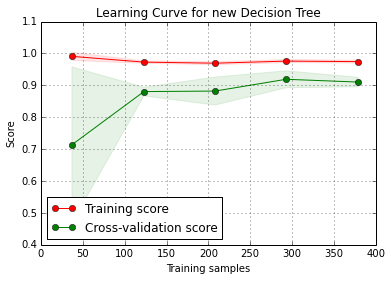

In [17]:
from sklearn.learning_curve import learning_curve

###Compute the learning curve
#<number of elements in train>,<train score>,<test score> = learning_curve(<classifier>,<data>,<targets>,train_sizes=<liste of training sizes>,cv=3)
#The list of training sizes can be absolute numbers or amount if between (0,1]
train_sizes_abs,train_scores,test_scores=learning_curve(new_dc,data,target,train_sizes=np.linspace(.1, 1.0, 5),cv=3)
###Visualize the learning curve (don't forget labels, title,legend,etc)

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=3,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training samples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(new_dc, 'Learning Curve for new Decision Tree', data, target, cv=3)
plt.show()
#You should see why I chose a 70%-30% ratio

<h4> <u>QUESTION 3 :</u> Why isn't the training score equal to one?</h4>
<p><i>The training score is not equal 1 because the Decision tree classifier was not able to classify all the dataset accurately. The minimum sample split used was 5</i></p>

<p>A second tool meant to investigate a specific parameter influence on scores is the <i>validation curve</i>. It is basically like a gridsearch with a single parameter. </p>

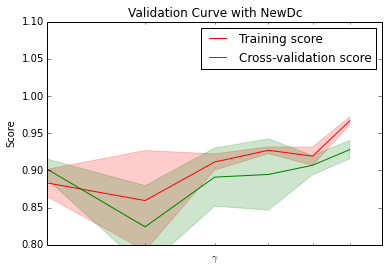

In [18]:
from sklearn.learning_curve import validation_curve

#Just an example
train_score,test_score = validation_curve(new_dc,data,target,param_name='max_depth',param_range=np.arange(2,8),cv=3)

###Plot the validation curve
param_range=np.arange(2,8)
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)

plt.title("Validation Curve with NewDc")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.xlim(2.0,8.0)
plt.ylim(0.8, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

<h3>Application - Evaluating the Random Forest classifier and the SVC</h3>

<p>In the following you will apply the evaluation and optimization tools to compare the Random Forest technique and the SVC technique.</p>

In [19]:
###Import the "RandomForestClassifier" classifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
###Train it on the training set
rfc=RandomForestClassifier()
#rfc.fit(x_train,target_train)

In [20]:
###Import the "SVC" classifier
from sklearn.svm import SVC
###Train it on the training set  (don't forget to scale it!)
from sklearn.preprocessing import scale
x_trains=scale(x_train)
svc=SVC()
#svc.fit(x_trains,target_train)

<p>Before evaluating the performance of both classifiers we will first determine the best values for their parameters</p>

In [21]:
###Using the grid search optimize the Random Forest Classifier
p_grid=dict({'criterion':['entropy','gini'],'min_samples_split':[2,5],'max_features':["auto","log2","sqrt"]})

#grd = GridSearchCV(<classifier>,cv=3,param_grid=<dictionary of parameters to investigate>)
#grd.fit(<training set>,<train set targets>)
grd = GridSearchCV(rfc,cv=3,param_grid=p_grid)
grd.fit(x_train,target_train)


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 5], 'max_features': ['auto', 'log2', 'sqrt'], 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [22]:
###Create a new Random Forest Classifier using the best parameters found
new_rfc = grd.best_estimator_
new_rfc.get_params

<bound method RandomForestClassifier.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [23]:
new_rfc.fit(x_train,target_train)
predrfc=new_rfc.predict(x_test)

In [24]:
###Using the grid search optimize the SVC Classifier
#(!don't forget to scale the data!)
p_grid=dict({'kernel':['linear','poly','rbf','sigmoid'],'decision_function_shape':['ovo','ovr'],'C':[1.0,3.0,5.0]})

#grd = GridSearchCV(<classifier>,cv=3,param_grid=<dictionary of parameters to investigate>)
#grd.fit(<training set>,<train set targets>)
x_trains=scale(x_train)
grd = GridSearchCV(svc,cv=3,param_grid=p_grid)
grd.fit(x_trains,target_train)


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [1.0, 3.0, 5.0], 'decision_function_shape': ['ovo', 'ovr']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [25]:
###Create a new Random Forest Classifier using the best parameters found
new_svc = grd.best_estimator_
new_svc.get_params
new_svc.fit(x_trains,target_train)
predsvc=new_svc.predict(scale(x_test))

<p>Now we have optimized out two classifier we can compare how they perform</p>

In [26]:
###Compute and the accuracy of both classifiers on the training set using the cross_val_score
# (!scale for SVC!)
score_rfc=cross_val_score(new_rfc,x_train,target_train)
score_svc=cross_val_score(new_svc,x_trains,target_train)

#Print the results (average and std)
print 'The mean for random forest classifier is',np.mean(score_rfc), 'and the Standard deviation is',np.std(score_rfc)
print 'The mean for SVC is',np.mean(score_svc), 'and the Standard deviation is',np.std(score_svc)

The mean for random forest classifier is 0.944729247361 and the Standard deviation is 0.0276712119018
The mean for SVC is 0.972412090833 and the Standard deviation is 0.0187348853094


<h4> <u>QUESTION 4 :</u> Which classifier gives the best accuracy?</h4>
<p><i>SVC gives the best accuracy</i></p>

In [27]:
###Print the Classification report for the Random Forest Classifier
print classification_report(target_test,predrfc,target_names='target')

             precision    recall  f1-score   support

          t       0.87      0.97      0.92        63
          a       0.98      0.92      0.95       108

avg / total       0.94      0.94      0.94       171



In [28]:
###Do the same for the SVC classifier
print classification_report(target_test,predsvc,target_names='target_names')

             precision    recall  f1-score   support

          t       0.97      0.97      0.97        63
          a       0.98      0.98      0.98       108

avg / total       0.98      0.98      0.98       171



<h4> <u>QUESTION 5 :</u> Analyze the last two classification reports.</h4>
<p><i>precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples. According to the report, SVC classifier produces better accuracy than Random forest classifier since it value of accuracy is higher. Also, the F1 score is also higher in SVC than Random forest classifier.</i></p>

<h4> <u>QUESTION 6 :</u> Recall the classification report from the optimized decision tree to conclude on the best algorithm to chose to efficiently detect malignant masses.</h4>
<p><i>Considering the three reports, SVC still performs better than the other two with an accuracy of 98% while Random forest classifier and Decision tree classifier performs almost the same way with accuracy of 94%. Hence, SVC is the best.</i></p>

<h4> <u>BONUS :</u> Repeat the optimization and evalution procedure with the k-nearest neighbors approach.</h4>
<p><i>Type your answer here</i></p>

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
p_grid=dict({'algorithm':['auto','ball_tree','kd_tree','brute'],'n_neighbors':[2,3,5,7,10],'weights':["uniform","distance"]})
knn = KNeighborsClassifier()
#grd = GridSearchCV(<classifier>,cv=3,param_grid=<dictionary of parameters to investigate>)
#grd.fit(<training set>,<train set targets>)
grd = GridSearchCV(knn,cv=3,param_grid=p_grid)
grd.fit(x_train,target_train)




GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [2, 3, 5, 7, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [31]:
new_knn = grd.best_estimator_
new_knn.get_params
new_knn.fit(x_train,target_train)
predknn=new_knn.predict(x_test)

In [32]:
score_knn=cross_val_score(new_knn,x_train,target_train)
print 'The mean for KNN is',np.mean(score_knn), 'and the Standard deviation is',np.std(score_knn)

The mean for KNN is 0.927128427128 and the Standard deviation is 0.0036859948044


In [33]:
print classification_report(target_test,predknn,target_names='target')

             precision    recall  f1-score   support

          t       0.94      0.94      0.94        63
          a       0.96      0.96      0.96       108

avg / total       0.95      0.95      0.95       171

